# Experimento com dados de 1 único poço

Nesse notebook será realizado as tarefas de obtenção de dados, tratamento, modelagem, e validação de dados.
O objetivo aqui é obter um classificador de anomalias para dados de 1 único poço.

A hipótese é que utilizando dados de apenas 1 poço, seja mais viável identificar padrões de anomalias.

**Dados do poço de id 5**:
- 68 normal events (979.530), 33 flow instability (271.487)
- 2 / 1 ou ( 3,6 / 1 )

Para uso nos testes preliminares de modelagem, será utilizado o poço de id 5. Motivos:
- possui boa quantidade de arquivos, e instâncias, normal e de anomalia;
- não tão desbalanceado em termos normal vs. anomalia;

## Aquisição de dados

In [1]:
# Environment configuration
import raw_data_manager.raw_data_acquisition as rda
import raw_data_manager.raw_data_inspector as rdi
import raw_data_manager.raw_data_splitter as rds
from data_exploration.metric_acquisition import MetricAcquisition
from data_preparation.transformation_manager import TransformationManager
from constants import utils, config
import pathlib

# Set default logging level.
from absl import logging
logging.set_verbosity(logging.DEBUG)

2023-09-11 13:28:34.327090: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 13:28:34.330238: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 13:28:34.398142: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 13:28:34.400355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 13:28:35.704979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
## Acquire data (of entire 3W dataset)
rda.acquire_dataset_if_needed()
latest_converted_data_path, latest_converted_data_version = (
    rda.get_latest_local_converted_data_version(config.DIR_PROJECT_DATA)
)

# Helper to overview metadata (of entire 3W dataset)
inspector_test_single_well_transformed = rdi.RawDataInspector(
    latest_converted_data_path,
    config.PATH_DATA_INSPECTOR_CACHE,
    True
)
metadata_train_single_well_transformed = inspector_test_single_well_transformed.get_metadata_table()
metadata_train_single_well_transformed

INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101
INFO:absl:Latest local version is 10101
INFO:absl:Going to fetch config file from $https://raw.githubusercontent.com/petrobras/3W/main/dataset/dataset.ini
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2786  100  2786    0     0   4433      0 --:--:-- --:--:-- --:--:--  4436
INFO:absl:Latest online version is 10101
INFO:absl:Found existing converted data with dataset version of 10101
INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101


,class_type,source,well_id,path,timestamp,file_size,num_timesteps
hash_id,,,,,,,
74203bb,NORMAL,REAL,1.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-24 03:00:00,491415,17885
9fbd6f9,NORMAL,REAL,2.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-09 06:00:00,520154,17933
28804c5,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-08 09:00:31,349162,17970
42afe91,NORMAL,REAL,8.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-07-01 14:01:35,251880,17799
fa71d94,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-23 19:00:00,279737,17949
...,...,...,...,...,...,...,...
ea66cf6,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2315903,61999
34f032a,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2259539,61999
876a969,SEVERE_SLUGGING,REAL,14.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-09-25 06:00:42,1005717,17959


In [3]:
selected_well_id = 5

# splits data, from the selected well, into train and test datasets
splitter = rds.RawDataSplitter(metadata_train_single_well_transformed, latest_converted_data_version)
split_train_dir_single_well, split_test_dir_single_well = splitter.stratefy_split_of_data(
    data_dir=config.DIR_PROJECT_DATA, 
    test_size=0.20,
    well_ids=[selected_well_id],
)

# generates metadata tables for split data
train_metadata_single_well = rdi.RawDataInspector(
    dataset_dir=split_train_dir_single_well,
    cache_file_path=config.DIR_PROJECT_CACHE / "train_metadata_single_well.parquet",
    use_cached=True
)
test_metadata_single_well = rdi.RawDataInspector(
    dataset_dir=split_test_dir_single_well,
    cache_file_path=config.DIR_PROJECT_CACHE / "test_metadata_single_well.parquet",
    use_cached=True
)

DEBUG:absl:size of train data: 95 --- size of test data: 24
DEBUG:absl:train path /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-5_train --- test path /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-5_test


DONE:   0%|          | 0/95 [00:00<?, ?it/s]

DONE:   0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
rdi.RawDataInspector.generate_table_by_anomaly_source(train_metadata_single_well.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,65,0,0,65
ABRUPT_INCREASE_BSW,0,0,0,0
SPURIOUS_CLOSURE_DHSV,0,0,0,0
SEVERE_SLUGGING,0,0,0,0
FLOW_INSTABILITY,30,0,0,30
RAPID_PRODUCTIVITY_LOSS,0,0,0,0
QUICK_RESTRICTION_PCK,0,0,0,0
SCALING_IN_PCK,0,0,0,0
HYDRATE_IN_PRODUCTION_LINE,0,0,0,0


In [5]:
rdi.RawDataInspector.generate_table_by_anomaly_source(test_metadata_single_well.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,16,0,0,16
ABRUPT_INCREASE_BSW,0,0,0,0
SPURIOUS_CLOSURE_DHSV,0,0,0,0
SEVERE_SLUGGING,0,0,0,0
FLOW_INSTABILITY,8,0,0,8
RAPID_PRODUCTIVITY_LOSS,0,0,0,0
QUICK_RESTRICTION_PCK,0,0,0,0
SCALING_IN_PCK,0,0,0,0
HYDRATE_IN_PRODUCTION_LINE,0,0,0,0


## Processamento dos dados

In [6]:
# Get cached metrics---standard deviation and average---to be used for data transformation
cache_file_name = config.CACHE_NAME_TRAIN_MEAN_STD_DEV
mean_and_std_metric_table = MetricAcquisition.get_mean_and_std_metric_from_cache(
    cache_file_name
)
mean_metric_list = mean_and_std_metric_table['mean_of_means']
std_metric_list = mean_and_std_metric_table['mean_of_stds']

mean_and_std_metric_table

,mean_of_means,mean_of_stds
P-PDG,1.650749e+07,1.201552e+07
P-TPT,1.517584e+07,3.687992e+06
T-TPT,1.061237e+02,1.629953e+01
P-MON-CKP,4.729793e+06,3.068575e+06
T-JUS-CKP,7.843213e+01,1.830099e+01
P-JUS-CKGL,3.501117e+08,2.450589e+08
QGL,2.603752e-01,1.638849e-01


In [7]:
tranformed_train_folder_name = split_train_dir_single_well.name
transformation_manager_single_well_train = TransformationManager(
    train_metadata_single_well.get_metadata_table(), 
    output_folder_base_name=tranformed_train_folder_name
)

DEBUG:absl:TransformationManager initialized with 95 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-5_train.


In [8]:
transformation_param_sample_interval_seconds=60
transformation_param_num_timesteps_for_window=20

transformation_manager_single_well_train.apply_transformations_to_table(
    output_parent_dir=config.DIR_PROJECT_DATA,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DONE:   0%|          | 0/95 [00:00<?, ?it/s]

In [9]:
import pathlib

X, y = TransformationManager.retrieve_pair_array(pathlib.Path("data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-5_train/0/WELL-00005_20170331160000.npz"))
X[0]

array([[-1.37384759,  1.52859103,  0.01403122,  2.22876907, -0.62375169,
         3.98697753, -1.58876885],
       [-1.37384759,  1.52841926,  0.01463482,  2.22580157, -0.62377898,
         3.98298019, -1.58876885],
       [-1.37384759,  1.52863934,  0.0145748 ,  2.22632863, -0.62380631,
         3.9805199 , -1.58876885],
       [-1.37384759,  1.52838622,  0.01474771,  2.22651357, -0.62383364,
         3.98600218, -1.58876885],
       [-1.37384759,  1.52843263,  0.01436324,  2.2260393 , -0.62386097,
         3.98502466, -1.58876885],
       [-1.37384759,  1.52873343,  0.0143935 ,  2.22543929, -0.62388828,
         3.98273188, -1.58876885],
       [-1.37384759,  1.52850458,  0.01523085,  2.2249339 , -0.6239156 ,
         3.98187229, -1.58876885],
       [-1.37384759,  1.52816315,  0.01513964,  2.22489398, -0.62394291,
         3.98494196, -1.58876885],
       [-1.37384759,  1.52820554,  0.01515774,  2.22466325, -0.62397023,
         3.98119042, -1.58876885],
       [-1.37384759,  1.5284

# Modelagem

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from constants import module_constants

num_features = X.shape[2]
num_outputs = module_constants.num_class_types

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(transformation_param_num_timesteps_for_window, num_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 9)                 909       
                                                                 
Total params: 17609 (68.79 KB)
Trainable params: 17609 (68.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Get transformed files paths
TRANSFORMATION_NAME_PREFIX = "transform-isdt-"
tranformed_train_single_well_dataset_dir = config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + tranformed_train_folder_name)

inspector_test_single_well_transformed = rdi.RawDataInspector(
    tranformed_train_single_well_dataset_dir,
    config.DIR_PROJECT_CACHE / "single_well_transformed.parquet",
    True
)
metadata_train_single_well_transformed = inspector_test_single_well_transformed.get_metadata_table()
transformed_train_data_single_well_file_path_list = metadata_train_single_well_transformed["path"]


def data_generator_loop(file_path_list):
    """Generator returning batches of data for each file path"""
    while True:
        for file_path in file_path_list:
            X, y = TransformationManager.retrieve_pair_array(pathlib.Path(file_path))
            yield X, y

def data_generator_non_loop(file_path_list):
    """Generator returning batches of data for each file path"""
    
    for file_path in file_path_list:
        X, y = TransformationManager.retrieve_pair_array(pathlib.Path(file_path))
        yield X, y

In [12]:
num_epochs = 15
# times the generator (data_gen) should be called to complete one full pass through your training dataset
steps_per_epoch = len(transformed_train_data_single_well_file_path_list)


train_data_gen = data_generator_loop(transformed_train_data_single_well_file_path_list)


# Train the model
model.fit(
    train_data_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs, 
    verbose=1
)

Epoch 1/15
95/95 [==============================] - 3s 16ms/step - loss: 0.5588 - accuracy: 0.8736
Epoch 2/15
95/95 [==============================] - 1s 14ms/step - loss: 0.1831 - accuracy: 0.9477
Epoch 3/15
95/95 [==============================] - 1s 13ms/step - loss: 0.0849 - accuracy: 0.9929
Epoch 4/15
95/95 [==============================] - 1s 15ms/step - loss: 0.0578 - accuracy: 0.9931
Epoch 5/15
95/95 [==============================] - 1s 13ms/step - loss: 0.0530 - accuracy: 0.9931
Epoch 6/15
95/95 [==============================] - 1s 15ms/step - loss: 0.0543 - accuracy: 0.9931
Epoch 7/15
95/95 [==============================] - 2s 17ms/step - loss: 0.0547 - accuracy: 0.9931
Epoch 8/15
95/95 [==============================] - 2s 16ms/step - loss: 0.0530 - accuracy: 0.9931
Epoch 9/15
95/95 [==============================] - 2s 16ms/step - loss: 0.0535 - accuracy: 0.9931
Epoch 10/15
95/95 [==============================] - 2s 18ms/step - loss: 0.0550 - accuracy: 0.9931
Epoch 11/

In [13]:
import numpy as np
test_file = transformed_train_data_single_well_file_path_list[-1]
print(test_file)

Xhat, yhat = TransformationManager.retrieve_pair_array(pathlib.Path(test_file))
print(f"True value: {yhat[0]}")

Xhat0 = Xhat[0].reshape(1, transformation_param_num_timesteps_for_window, num_features)
print(f"Predicted value: {model.predict(Xhat0)}")

/home/ubuntu/lemi_3w/data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-5_train/4/WELL-00005_20170624060038.npz
True value: [0. 0. 0. 0. 1. 0. 0. 0. 0.]
1/1 [==============================] - 0s 264ms/step
Predicted value: [[0. 0. 0. 0. 1. 0. 0. 0. 0.]]


# Validação

Aqui pegaremos nosso banco de testes, o transformaremos, para então o utilizar para validar a perfomance do nosso modelo.

In [14]:
tranformed_test_folder_name = split_test_dir_single_well.name

test_transformation_manager_single_well = TransformationManager(
    test_metadata_single_well.get_metadata_table(), 
    output_folder_base_name=tranformed_test_folder_name
)

test_transformation_manager_single_well.apply_transformations_to_table(
    output_parent_dir=config.DIR_PROJECT_DATA,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

# Get transformed files paths
test_tranformed_single_well_dataset_dir = config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + tranformed_test_folder_name)

inspector_test_single_well_transformed = rdi.RawDataInspector(
    test_tranformed_single_well_dataset_dir,
    config.DIR_PROJECT_CACHE / "single_well_transformed_test.parquet",
    True
)
test_metadata_single_well_transformed = inspector_test_single_well_transformed.get_metadata_table()
test_transformed_data_single_well_file_path_list = test_metadata_single_well_transformed["path"]
test_transformed_data_single_well_file_path_list

DEBUG:absl:TransformationManager initialized with 24 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-5_test.


DONE:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:absl:Processing 16 events of class type 0.


DONE:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:absl:Processing 8 events of class type 4.


DONE:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:absl:Processing 0 events of class type 5.
INFO:absl:Processing 0 events of class type 1.
INFO:absl:Processing 0 events of class type 7.
INFO:absl:Processing 0 events of class type 6.
INFO:absl:Processing 0 events of class type 8.
INFO:absl:Processing 0 events of class type 2.
INFO:absl:Processing 0 events of class type 3.
INFO:absl:Found 2. The first one is [EventMetadata(hash_id='e8e74a1747e0d4b5f4d0ccf5b0373835f6a1aade9d5a8f93f123b8a0b45c6b72', class_type='NORMAL', source='REAL', well_id=5, path='/home/ubuntu/lemi_3w/data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-5_test/0/WELL-00005_20170817200000.npz', timestamp=Timestamp('2017-08-17 20:00:00'), file_size=184294, num_timesteps=None), EventMetadata(hash_id='26547637056cd68fcef5f4c043e13182935b0062fc33c72b0287ad561c687ec6', class_type='NORMAL', source='REAL', well_id=5, path='/home/ubuntu/lemi_3w/data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-5_test/0/WELL-00005_20

hash_id
e8e74a1    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
2654763    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
49e6319    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
42bfced    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
ea7aff1    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
9979b51    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
307eb1b    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
5e3b2f6    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
d19ab4f    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
f236799    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
59047d9    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
ea14388    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
d537387    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
1880c70    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
dcb0ebd    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
ef75e98    /home/ubuntu/lemi_3w/data/transform-isdt-datas...
657563a    /home

In [19]:
test_data_gen = data_generator_non_loop(test_transformed_data_single_well_file_path_list)
num_steps = len(test_transformed_data_single_well_file_path_list)

model.evaluate(
    test_data_gen,
    verbose=1,
    #steps=num_steps,
)

24/24 [==============================] - 0s 10ms/step - loss: 0.0142 - accuracy: 1.0000


[0.01415830198675394, 1.0]

In [28]:
test_data_gen = data_generator_non_loop(test_transformed_data_single_well_file_path_list)

y_test_predictions = model.predict(
    test_data_gen,
)

f"Number of predictions: {len(y_test_predictions)}", f"Shape of y array: {y_test_predictions.shape}", y_test_predictions[0]

24/24 [==============================] - 0s 13ms/step


('Number of predictions: 3962',
 'Shape of y array: (3962, 9)',
 array([9.9505484e-01, 6.3994203e-06, 1.5943642e-06, 1.3502416e-05,
        4.8980555e-03, 1.7195862e-05, 2.3623995e-06, 1.1378401e-06,
        4.9455612e-06], dtype=float32))

In [30]:
test_data_gen = data_generator_non_loop(test_transformed_data_single_well_file_path_list)
y_test_labels = []

for X, y in test_data_gen:
    y_test_labels.append(y)

y_test_labels = np.concatenate(y_test_labels, axis=0)

f"Number of predictions: {len(y_test_labels)}", f"Shape of y array: {y_test_labels.shape}", y_test_labels[0]

('Number of predictions: 3962',
 'Shape of y array: (3962, 9)',
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [37]:
from tensorflow.math import confusion_matrix

y_test_labels_1d = np.argmax(y_test_labels, axis=1)
y_test_predictions_1d = np.argmax(y_test_predictions, axis=1)

confusion_matrix(
    y_test_labels_1d,
    y_test_predictions_1d,
    num_classes=num_outputs,
)

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[3155,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  807,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)>

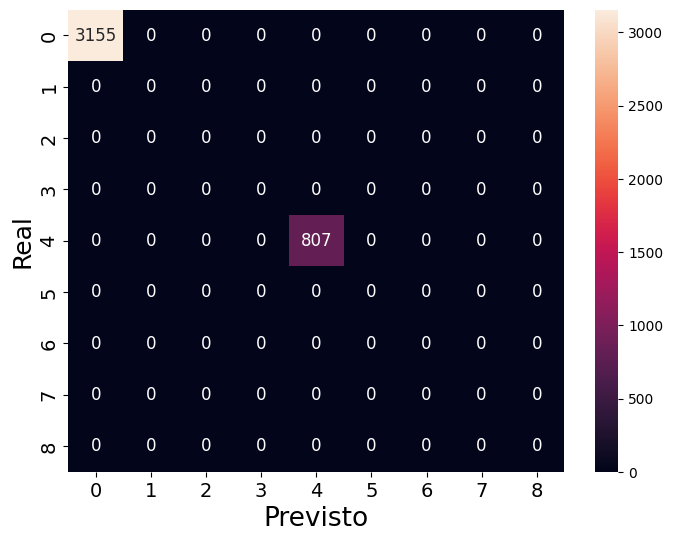

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from raw_data_manager.models import EventClassType

consusion_array = np.array([[3155,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  807,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]],)

fig, ax = plt.subplots(figsize=(8,6))
heatmap = sns.heatmap(consusion_array, annot=True, fmt='d', xticklabels=[e.value for e in EventClassType], yticklabels=[e.value for e in EventClassType], annot_kws={"size": 12})
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 14)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 14)


plt.ylabel('Real', fontsize=18)
plt.xlabel('Previsto', fontsize=19)
plt.show()

